<a href="https://colab.research.google.com/github/LeonardoVieiraGuimaraes/MiniCursoPalestra/blob/main/CNN/reconhecerNumero/inference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/LeonardoVieiraGuimaraes/MiniCursoPalestra/blob/main/CNN/inference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inferência com modelo treinado (MNIST) — Colab / Local

Resumo: Este notebook carrega um modelo treinado (CNN para MNIST) e faz inferência em imagens únicas ou em lote. Foi escrito para funcionar no Google Colab ou em Jupyter local.

Pré-requisitos:
- Modelo salvo em um dos caminhos: `/content/drive/MyDrive/simple_cnn_mnist.h5` (Drive), `simple_cnn_mnist.h5` ou `best_model.h5` (runtime).
- Bibliotecas: TensorFlow, Pillow, numpy, matplotlib (Colab geralmente fornece tudo).

Como usar (resumo):
1. (Opcional) Monte o Google Drive se o modelo estiver lá.
2. Execute a célula de carregamento do modelo.
3. Faça upload de uma imagem (ou forneça uma URL) e execute a célula de pré-processamento + inferência.
4. Para processamento em lote, utilize a célula de upload CSV (se disponível) ou modifique para iterar sobre um diretório de imagens.

Observações:
- O modelo espera imagem 28x28 grayscale normalizada em [0,1]. O notebook converte entradas coloridas automaticamente.
- Se o modelo não for encontrado, execute o notebook de treino (`simple_cnn_colab.ipynb`) e salve o modelo no Drive ou no runtime.

Cell 3 — Observações rápidas:
Verifica os caminhos de modelo comuns e as expectativas de formato de imagem. Útil para evitar erros na carga do modelo.

## Observações
- Este notebook assume que o modelo foi salvo num dos caminhos: `/content/drive/MyDrive/simple_cnn_mnist.h5` (Drive), `simple_cnn_mnist.h5` ou `best_model.h5` (runtime).
- O modelo espera imagens 28x28 em escala de cinza, normalizadas em [0,1]. Se fornecer imagens coloridas, o notebook fará a conversão.

Cell 4 — Montar Drive:
Esta célula monta o Google Drive quando executada em Colab. Se estiver em ambiente local, apenas imprime mensagem indicando uso local. Execute para disponibilizar modelos salvos no Drive.

In [1]:
# Célula 1 — montar Drive se estiver no Colab (opcional)
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    print('Montando Google Drive em /content/drive ...')
    drive.mount('/content/drive')
else:
    print('Não detectado Colab. Usando ambiente local.')

Montando Google Drive em /content/drive ...
Mounted at /content/drive


Cell 5 — Localizar modelo:
Procura o modelo em uma lista de caminhos comuns e carrega o primeiro que existir. Se nenhum for encontrado, orienta salvar o modelo primeiro.

In [2]:
# Célula 2 — localizar e carregar o modelo salvo
import os
from tensorflow.keras.models import load_model

candidate_paths = []
candidate_paths.append('/content/drive/MyDrive/simple_cnn_mnist.h5')
candidate_paths.append('simple_cnn_mnist.h5')
candidate_paths.append('best_model.h5')

model_path = None
for p in candidate_paths:
    if os.path.exists(p):
        model_path = p
        break

if model_path is None:
    print('Modelo não encontrado nos caminhos padrão.')
    print('Salve o modelo em Drive (MyDrive/simple_cnn_mnist.h5) ou no runtime (simple_cnn_mnist.h5) e reexecute esta célula.')
else:
    print('Carregando modelo de', model_path)
    model = load_model(model_path)
    print('Modelo carregado com sucesso.')

Carregando modelo de /content/drive/MyDrive/simple_cnn_mnist.h5


Modelo carregado com sucesso.


Cell 6 — Preparar biblioteca de imagem:
Garante que Pillow esteja disponível (instala no Colab quando necessário) e importa utilitários para leitura/processamento de imagem.

In [3]:
# Célula 3 — instalar Pillow em Colab se necessário
try:
    from PIL import Image
except Exception:
    if IN_COLAB:
        import subprocess, sys
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'pillow'])
        from PIL import Image
    else:
        raise

from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

print('Pillow disponível, carregamento de imagens pronto.')

Pillow disponível, carregamento de imagens pronto.


Cell 7 — Instruções de upload:
Explica as opções para carregar uma imagem: upload direto (Colab/Jupyter) ou fornecer uma URL. Leia antes de executar a célula de upload.

## Carregar uma imagem
Opções:
- Fazer upload direto do seu computador (Colab/Jupyter).
- Fornecer uma URL de imagem (o notebook baixa a imagem).

Cell 8 — Upload/URL:
Tenta primeiro abrir o widget de upload no Colab; em seguida, oferece alternativas para Jupyter local ou baixar por URL. Defina `image_url` se preferir baixar automaticamente.

In [4]:
# Célula 4 — fazer upload ou baixar por URL
image_path = None

# 1) Primeiro tentamos upload via widget (funciona no Colab/Jupyter)
try:
    from google.colab import files as colab_files
    uploaded = colab_files.upload()  # abre diálogo no Colab
    if uploaded:
        # pega o primeiro arquivo enviado
        image_path = list(uploaded.keys())[0]
        print('Arquivo enviado:', image_path)
except Exception:
    try:
        # Em Jupyter local, usar IPython widgets alternativa
        from IPython.display import display
        import ipywidgets as widgets
        uploader = widgets.FileUpload(accept='image/*', multiple=False)
        display(uploader)
        print('Use o widget acima para selecionar um arquivo e depois execute a célula novamente.')
    except Exception:
        print('Upload não disponível — forneça uma URL manualmente.')

# 2) Se não houver upload, você pode definir uma URL aqui:
image_url = ''  # exemplo: 'https://example.com/digit.png'
if image_path is None and image_url:
    print('Baixando imagem de URL...', image_url)
    try:
        import requests
        resp = requests.get(image_url)
        img_bytes = resp.content
        with open('input_image.png', 'wb') as f:
            f.write(img_bytes)
        image_path = 'input_image.png'
    except Exception as e:
        print('Falha ao baixar a imagem:', e)

print('image_path =', image_path)

Saving quatro.jpg to quatro.jpg
Arquivo enviado: quatro.jpg
image_path = quatro.jpg


Cell 9 — Pré-processamento e inferência:
Define funções para redimensionar/normalizar a imagem e executar a previsão usando o modelo carregado. Também mostra a imagem de entrada com a predição.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
Predição: 4  (prob=0.5208)


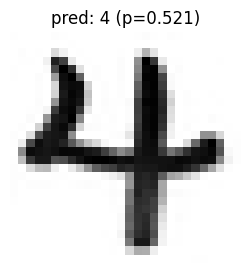

In [5]:
# Célula 5 — preprocessing e inferência
def get_resample_method():
    # Compatibilidade com diferentes versões do Pillow
    try:
        return Image.Resampling.LANCZOS
    except Exception:
        try:
            return Image.LANCZOS
        except Exception:
            try:
                return Image.ANTIALIAS
            except Exception:
                return Image.BICUBIC

resample_method = get_resample_method()

def preprocess_image(path_or_bytes, target_size=(28,28)):
    # aceita path (str) ou bytes
    if isinstance(path_or_bytes, bytes):
        img = Image.open(BytesIO(path_or_bytes))
    else:
        img = Image.open(path_or_bytes)
    # converter para grayscale e redimensionar usando resample_method
    img = img.convert('L').resize(target_size, resample_method)
    arr = np.array(img).astype('float32') / 255.0
    arr = np.expand_dims(arr, axis=-1)  # (28,28,1)
    arr = np.expand_dims(arr, axis=0)   # (1,28,28,1)
    return arr

# Se image_path foi definido (upload), executa previsão
if 'image_path' in globals() and image_path:
    try:
        x = preprocess_image(image_path)
        preds = model.predict(x)
        label = int(np.argmax(preds, axis=1)[0])
        prob = float(np.max(preds))
        print(f'Predição: {label}  (prob={prob:.4f})')
        # mostrar imagem de entrada
        plt.figure(figsize=(3,3))
        img = Image.open(image_path).convert('L').resize((28,28), resample_method)
        plt.imshow(img, cmap='gray')
        plt.title(f'pred: {label} (p={prob:.3f})')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print('Erro ao processar ou predizer imagem:', e)
else:
    print('Nenhuma imagem fornecida. Use upload (Colab) ou defina image_url na célula de upload.')

Cell 10 — Notas finais:
Dicas rápidas sobre tipos de imagem suportados e como proceder caso o modelo não seja encontrado.

---
### Notas finais
- Se quiser testar com imagens contendo um único dígito manuscrito, a inferência deve funcionar bem. Para imagens maiores ou coloridas, o notebook converte para 28x28 grayscale.
- Se o modelo não for encontrado, volte ao notebook de treino e execute a célula de salvamento no Drive ou salve o arquivo em `simple_cnn_mnist.h5`.

Se quiser, eu adapto este notebook para reconhecer imagens CIFAR-10 (coloridas) ou para processar múltiplas imagens em lote.